# Idea of Heterodyne demodulation measurements

This a summary of the APR paper on introduction to quantum engineering focused on the readout part with heterodyne measurements

## Representation of the readout signal

The input signal $s(t)$ is assumed to be of the form :

$s(t) = Re\{A_{RO}e^{j\theta_{RO}}e^{j\omega_{RO}t}\}$

Where the phasor contains the information for the in-phase and quadrature component:

$A_{RO}e^{j\theta_{RO}}=A_{RO}\cos{\theta_{RO}}+jA_{RO}\sin{\theta_{RO}}\equiv{I+jQ}$


## Heterodyne demodulation

This measurements is processed in several steps.
1. Mixing of the output signal, $s(t)$ at frequency $\omega_{RO}$, with a local oscillator at frequency $\omega_{LO}$, such that $\omega_{IF}=\left|\omega_{RO}-\omega_{LO}\right|>0$. The signals are extracted. We then obtain $I_{IF}\left(t\right)\propto \cos{\left(\omega_{IF}t+\theta_{RPO}\right)}$ and $Q_{IF}\left(t\right)\propto \sin{\left(\omega_{IF}t+\theta_{RPO}\right)}$ with a $\pi/2$ phase. 


2. Using Analog-to-Digital Converters (ADCs), we digitalized the signal, to generate $I_{IF}\left[n\right]\propto \cos{\left(\Omega_{IF}n+\theta_{RPO}\right)}$ and $Q_{IF}\left[n\right]\propto \sin{\left(\Omega_{IF}n+\theta_{RPO}\right)}$, with $n=t/\Delta{t}$ the sample number over the continuous time, $\Omega_{IF}=\omega_{IF}\Delta{t}$ the digital frequency and $\Delta{t}$ the sampling period. (Part 1. can be performed at the same time as part 2. in the FPGA.


Before continuing the measurement process, we can introduce the analytic function, $z_{IF}\left[n\right]$,defined in the complex plane I-Q.

$z_{IF}\left[n\right] = I_{IF}\left[n\right]+jQ_{IF}\left[n\right] \equiv V_I\left[n\right] + jV_Q\left[n\right]$

$= \frac{A_{RO}A_{LO}}{8}\left[cos{\left(\Omega_{IF}n+\theta_{RPO}\right)}+jsin{\left(\Omega_{IF}n+\theta_{RPO}\right)}\right]$

$= \frac{A_{RO}A_{LO}}{8}e^{j\theta_{RO}}e^{j\Omega_{IF}n}$

3. Now we extract the $z_{IF}\left[n\right]$ after a time $\tau_{rd}$ so that our signal is stabilized, which correspond of extracting the signal in a range $[n_1:n_2]$.


4. Finally we demodulate the time serie multiplying point by point $z_{IF}\left[n\right]$ by $e^{-j\Omega_{IF}n}$ to extract the phasor term.

$z\left[n\right] = z_{IF}\left[n\right].*e^{-j\Omega_{IF}n}$

5. Averaging all the points


6. Repeat the procedure a high number of time to reconstruct the map. In the review paper it's indicated $10^6$ times.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
sns.set()

Firstly, we generate the signals the readout and the local oscillator

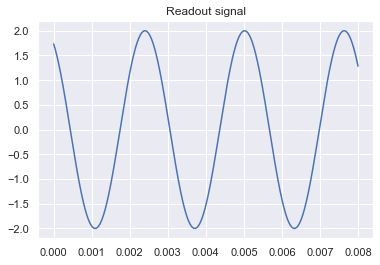

In [85]:
###Fake readout signal, we start with a simple cosine signal###

#Amplitude of the signal
A_RO = 2

#Frequency of the signal
omega_RO = 300e6

#Sampling period
dt = 8e-6

#Digital frequency of the signal
Omega_RO = omega_RO*dt

#Phase of the signal
theta_RO = np.pi/6

#Time of acquisition
t = 8e-3

#Sampling range
n = t/dt

#Array of sampling points
n_array = np.arange(0,t,dt)

#Signal

RO = A_RO*np.cos(Omega_RO*n_array + theta_RO)

plt.title('Readout signal')
plt.plot(n_array,RO)
plt.show()

Let's now make this signal more realistic by adding some gaussian noise

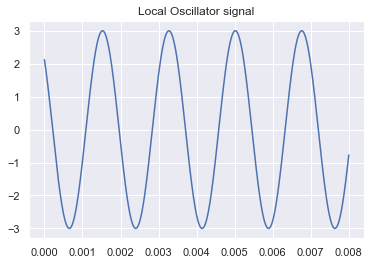

In [84]:
###Fake local oscillator signal, we start with a simple cosine signal###
#Modify program to make proper pulses.

#We already define our intermediate frequency here
omega_IF = 150e6
Omega_IF = omega_IF*dt

#Amplitude of the signal
A_LO = 3

#Frequency of the signal
omega_LO = omega_RO + omega_IF

#Sampling period (We use the same sampling rate here)
dt = 8e-6

#Digital frequency of the signal
Omega_LO = omega_LO*dt

#Phase of the signal
theta_LO = np.pi/4

#Time of acquisition(Same tile of acquisition)
t = 8e-3

#Sampling range
n = t/dt

#Array of sampling points
n_array = np.arange(0,t,dt)

#Signal

LO = A_LO*np.cos(Omega_LO*n_array + theta_LO)

plt.title('Local Oscillator signal')
plt.plot(n_array,LO)
plt.show()

### 1. Mixing of the two signals

We use the trigonemetric properties that:

$\cos(a)\cos(b)=\frac{1}{2}(\cos(a+b)+\cos(a-b))$

and

$\sin(a)\cos(b)=\frac{1}{2}(\sin(a+b)+\sin(a-b))$

And we just filter out the frequencies that are too high

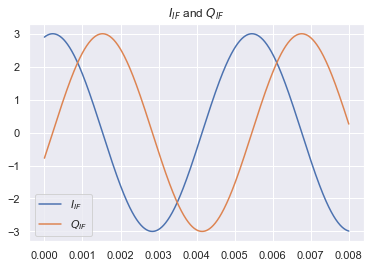

In [83]:
#Mixing of the signal to get two signals I and Q multiplied by a phase difference of pi/2~

#I (Without pi/2 phase shift)

I = ((A_RO*A_LO)/2)*(np.cos(Omega_RO*n_array + theta_RO + Omega_LO*n_array + theta_LO)+np.cos(omega_IF*dt*n_array+theta_RO-theta_LO))

#Q with phase shift on the local oscillator cos->sin

Q = ((A_RO*A_LO)/2)*(np.sin(Omega_RO*n_array + theta_RO + Omega_LO*n_array + theta_LO)+np.sin(omega_IF*dt*n_array+theta_RO-theta_LO))


#High Frequency filter applied, we just keep the terms in omega_IF

I_IF = ((A_RO*A_LO)/2)*(np.cos(omega_IF*dt*n_array+theta_RO-theta_LO))

Q_IF = ((A_RO*A_LO)/2)*(np.sin(omega_IF*dt*n_array+theta_RO-theta_LO))


plt.title(r'$I_{IF}$ and $Q_{IF}$')
plt.plot(n_array,I_IF,label = r'$I_{IF}$')
plt.plot(n_array,Q_IF, label = r'$Q_{IF}$')
plt.legend()
plt.show()

### 2. ADC conversion

We now digitize our signal. For the sake of the simulation we will use quite low values.

In [58]:
#Step for digitization
dt_d = 8e-3

#For the moment no digitalization


### Switching to complex plane 

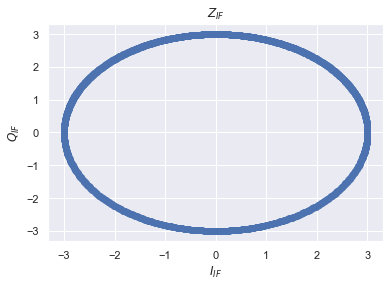

In [82]:
Z_IF = I_IF + 1j*Q_IF

plt.title(r'$Z_{IF}$')
plt.xlabel(r'$I_{IF}$')
plt.ylabel(r'$Q_{IF}$')
plt.scatter(Z_IF.real,Z_IF.imag)
plt.show()

### 4. Demodulation

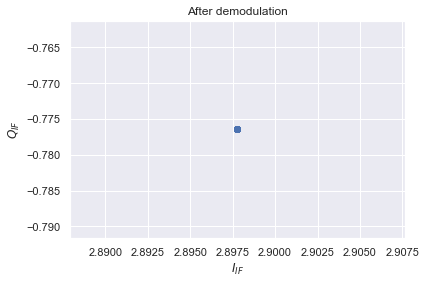

In [81]:
#Multiply the array by complex modulus of the 
z = Z_IF*np.exp(-1j*Omega_IF*n_array)

plt.title('After demodulation')
plt.xlabel(r'$I_{IF}$')
plt.ylabel(r'$Q_{IF}$')
plt.scatter(z.real,z.imag)
plt.show()

### 5. Averaging all the points

In [80]:
z_av = 1/len(n_array)*sum(z)
print(z_av)

(2.8977774788672503-0.7764571353075478j)


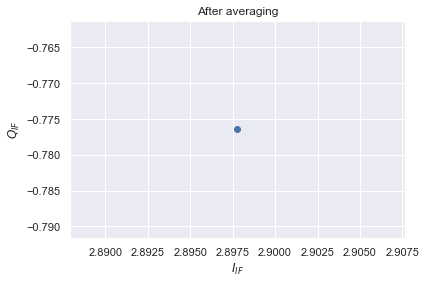

In [86]:
plt.title('After averaging')
plt.xlabel(r'$I_{IF}$')
plt.ylabel(r'$Q_{IF}$')
plt.scatter(z_av.real,z_av.imag)
plt.show()

In [89]:
Phase = np.angle(z_av)
Norm = np.sqrt(z_av.real**2+z_av.imag**2)

In [93]:
print('Phase :',Phase)
print('Norm :',Norm)

Phase : -0.26179938779914086
Norm : 3.00000000000004
